# Upload files in Google Colab
If you are running this Jupyter Notebook on Google Colab, run this cell to upload the data files (train_inputs.csv, train_targets.csv, test_inputs.csv, test_targets.csv) in the colab virtual machine.  You will be prompted to select files that you would like to upload. 

If you are running this Jupyter Notebook on your computer, you do not need to run this cell.

In [ ]:
from google.colab import files
uploaded = files.upload()
%ls

# Import libraries 
Do not use any other Python library.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function: load_gaussian_process_data

This function loads the data for Gaussian Process Regression from a local drive into RAM

Outputs:

*   **train_inputs**: numpy array of N training data points x M features
*   **train_targets**: numpy array of N training targets
*   **test_inputs**: numpy array of N' test data points x M features
*   **test_targets**: numpy array of N' test targets

In [ ]:
def load_gaussian_process_data():
    test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
    test_targets = np.genfromtxt('test_targets.csv', delimiter=',')
    train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
    train_targets = np.genfromtxt('train_targets.csv', delimiter=',')
    return train_inputs, train_targets, test_inputs, test_targets

# Function: predict_gaussian_process

This function computes the mean and variance of the Gaussian posterior distribution over the outputs given some inputs.

Inputs:
*   **inputs**: matrix of input data points for which we want to make a prediction (numpy array of N data points x M features)
*   **posterior**: function that computes Gaussian posterior distributions over the outputs given some inputs

Output:
*   **mean**: vector of mean values (numpy array of N floats)
*   **variance**: vector of variance values (numpy array of N floats)

In [ ]:
def predict_gaussian_process(inputs, posterior):

    mean, variance = posterior(inputs)
    return mean, variance

# Function eval_gaussian_process

This function evaluates a set of predictions by computing the mean squared error with respect to the targets.  More precisely, compute the mean squared error between the means of the Gaussian posteriors and the targets. 

Inputs:
*   **inputs**: matrix of input data points for which we will evaluate the predictions (numpy array of N data points x M features)
*   **posterior**: function that computes Gaussian posterior distributions over the outputs given some inputs (function)
*   **targets**: vector of targets associated with the inputs (numpy array of N targets)

Output:
*   **mean_squared_error**: mean squared error between the predicted Gaussian means and the targets (scalar)

In [ ]:
def eval_gaussian_process(inputs, posterior, targets):
  
    mean, variance = predict_gaussian_process(inputs, posterior)
    mean_squared_error = np.square(np.subtract(mean, targets)).mean()
    return mean_squared_error

# Function train_gaussian_process

This function trains a Gaussian process.  More precisely, compute the inverse regularized gram matrix $(K+ \sigma^2 I)^{-1}$ and then define a function that computes a posterior based on this inverse regularized gram matrix.

Inputs:
*   **train_inputs**: matrix of input training points (numpy array of N data points x M features)
*   **train_targets**: vector of targets associated with the inputs (numpy array of N targets)
*   **measurement_variance**: Variance $\sigma^2$ of the measurement noise in the likelihood distribution $P({\bf y}|{\bf X},f) = N(f({\bf X}),\sigma^2{\bf I})$ (scalar)
*   **kernel**: function that computes the kernel between two sets of inputs (function)
*   **kernel_param**: parameter for the kernel (scalar)

Output:
*   **posterior**: function that computes Gaussian posterior distributions over the outputs given some inputs (function)



In [ ]:
def train_gaussian_process(train_inputs, train_targets, measurement_variance, kernel, kernel_param):

  # dummy assignment until this function is filled in
  inverse_regularized_gram_matrix = np.linalg.inv(kernel(train_inputs, train_inputs, kernel_param) + (measurement_variance * np.identity(len(train_inputs))))

  # define a function that computes a posterior distribution over the outputs given some inputs
  # inputs: 
  #     inputs: matrix of input points for which we would like to predict a Gaussian over the outputs (numpy array of N' data points x M features)
  #     train_inputs: matrix of train inputs that serve as evidence for the posterior (numpy array of N data points x M features)
  #     train_targets: vector of train targets that serve as evidence for the posterior (numpy array of N targets)
  #     inverse_regularized_gram_matrix: (K + sigma^2 I)^{-1}
  # outputs:
  #     mean: vector of Gaussian means for each prediction (numpy array of N' means)
  #     variance: vector of Gaussian variances for each prediction (numpy array of N' variances)
  def posterior(inputs, train_inputs=train_inputs, train_targets=train_targets, inverse_regularized_gram_matrix=inverse_regularized_gram_matrix, kernel=kernel):

    mean = np.matmul(np.matmul(kernel(inputs, train_inputs, kernel_param), inverse_regularized_gram_matrix), train_targets)
    variance = kernel(inputs, inputs, kernel_param) + measurement_variance*np.identity(len(inputs)) - \
    np.matmul(np.matmul(kernel(inputs, train_inputs, kernel_param), inverse_regularized_gram_matrix), kernel(train_inputs, inputs, kernel_param))
    return mean, variance

  return posterior

# Function identity_kernel

This function computes the identity kernel: $k(x,x') = x^T x'$. 

Inputs:
*   **inputs1**: matrix of input points (numpy array of N data points x M features)
*   **inputs2**: matrix of input points (numpy array of N' data points x M features)
*   **dummy_param**: this argument is never used since the identity kernel does not have any parameter (default value: None)

Outputs:
*   **gram_matrix**: matrix of kernel values (numpy array of N x N' values)

In [ ]:
def identity_kernel(inputs1,inputs2,dummy_param=None):

    gram_matrix = np.matmul(inputs1, inputs2.T)
    return gram_matrix

# Function polynomial_kernel

This function computes the polynomial kernel: $k(x,x') = (x^T x' + 1)^d$. 

Inputs:
*   **inputs1**: matrix of input points (numpy array of N data points x M features)
*   **inputs2**: matrix of input points (numpy array of N' data points x M features)
*   **degree**: exponent d in the kernel (integer)

Outputs:
*   **gram_matrix**: matrix of kernel values (numpy array of N x N' values)

In [ ]:
def polynomial_kernel(inputs1,inputs2,degree):

    gram_matrix = np.power((np.matmul(inputs1, inputs2.T) + 1), degree)
    return gram_matrix

# Function gaussian_kernel

This function computes the Gaussian kernel: $k(x,x') = e^{-\frac{||x- x'||_2^2}{2w^2}}$. 

Inputs:
*   **inputs1**: matrix of input points (numpy array of N data points x M features)
*   **inputs2**: matrix of input points (numpy array of N' data points x M features)
*   **width**: width w of the Gaussian kernel (scalar)

Outputs:
*   **gram_matrix**: matrix of kernel values (numpy array of N x N' values)

In [ ]:
def gaussian_kernel(inputs1,inputs2,width):

    n1 = len(inputs1)
    n2 = len(inputs2)
    gram_matrix = np.zeros((inputs1.shape[0],inputs2.shape[0]))
    for i in range(n1):
        for j in range(n2):
            gram_matrix[i][j] = np.exp(-np.square(np.linalg.norm(inputs1[i] - inputs2[j])) / (2 * (width ** 2)))
    return gram_matrix

# Function cross_validation_gaussian_process

This function performs k-fold cross validation to determine the best kernel parameter in Gaussian process regression

Inputs:
*   **k_folds**: # of folds in cross-validation (integer)
*   **kernel**: function that computes a kernel (function)
*   **hyperparameters**: list of parameters for the kernel (list of scalars)
*   **inputs**: matrix of input points (numpy array of N data points by M features)
*   **targets**: vector of targets associated with the inputs (numpy array of N targets)
*   **measurement_variance**: Variance $\sigma^2$ of the measurement noise in the likelihood distribution $P({\bf y}|{\bf X},f) = N(f({\bf X}),\sigma^2{\bf I})$ (scalar)

Outputs:
*   **best_hyperparam**: best parameter for the kernel (scalar)
*   **best_mean_squared_error**: mean squared error achieved with best_hyperparam (float)
*   **mean_squared_errors**: vector of mean squared errors for the corresponding hyperparameters (numpy array of floats)



In [ ]:
def cross_validation_gaussian_process(k_folds, kernel, hyperparameters, inputs, targets, measurement_variance):

    splited_input = np.array_split(inputs, k_folds)
    splited_targets = np.array_split(targets, k_folds)
    best_hyperparam = 0
    best_mean_squared_error = 0
    mean_squared_errors = []
    offset = int(len(inputs) / k_folds)
    start = True
    for lambda_hyperparam in hyperparameters:
        mse = 0
        for i in range(k_folds):
            validation_x = splited_input[i]
            validation_y = splited_targets[i]
            train_x = np.concatenate(splited_input[:i] + splited_input[i+1:])
            train_y = np.concatenate(splited_targets[:i] + splited_targets[i+1:])
            posterior = train_gaussian_process(train_x, train_y, measurement_variance, kernel, lambda_hyperparam)
            mse += eval_gaussian_process(validation_x, posterior, validation_y)
        avg_mse = mse / float(k_folds)
        mean_squared_errors.append(avg_mse)
        if (start):
            best_mean_squared_error = avg_mse
            start = False
        if (avg_mse < best_mean_squared_error):
            best_mean_squared_error = avg_mse
            best_hyperparam = lambda_hyperparam
    return best_hyperparam, best_mean_squared_error, mean_squared_errors

# Function: plot_gaussian_process_mean_squared_errors

Function that plots the mean squared errors for different hyperparameters in Gaussian process regression based on cross validation

Inputs:
*   **mean_squared_errors**: vector of mean squared errors for the corresponding hyperparameters (numpy array of floats)
*   **hyperparams**: list of hyperparameters where each hyperparameter is a different lambda value (list of floats)
*   **xlabel**: string to label the x-axis (string)

In [ ]:
def plot_gaussian_process_mean_squared_errors(mean_squared_errors,hyperparams,xlabel):
    plt.plot(hyperparams,mean_squared_errors)
    plt.ylabel('mean squared error')
    plt.xlabel(xlabel)
    plt.show()

# Main Gaussian Process code

Load data.  Then evaluate the identity kernel, polynomial kernel and Gaussian kernel.



Identity Kernel
test mean squared error with identity kernel: 3.59055329679847

Polynomial Kernel


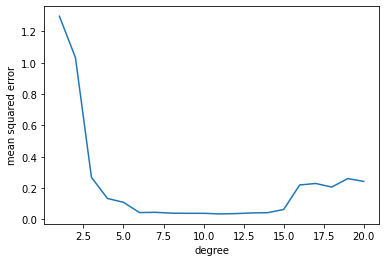

best degree: 11
best cross validation mean squared error: 0.034371160412335997
test mean squared error with polynomial kernel: 0.030292766998362274

Gaussian Kernel


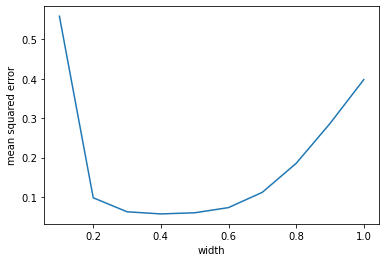

best width: 0.4
best cross validation mean squared error: 0.057148773975383406
test mean squared error with Gaussian kernel: 0.043025161668200446


In [ ]:
# load data
train_inputs, train_targets, test_inputs, test_targets = load_gaussian_process_data()

# likelihood parameter (see definition of train_gaussian_process for more details)
measurement_variance = 1

# number of folds in k-fold cross validation
k_folds = 10

# identity kernel
print('\nIdentity Kernel')
posterior = train_gaussian_process(train_inputs, train_targets, measurement_variance, identity_kernel, None)
mean_squared_error = eval_gaussian_process(test_inputs, posterior, test_targets)
print('test mean squared error with identity kernel: ' + str(mean_squared_error))

# polynomial kernel
print('\nPolynomial Kernel')
# degrees to be evaluated by cross validation
hyperparams = range(1,21)
best_degree, best_mean_squared_error, mean_squared_errors = \
  cross_validation_gaussian_process(k_folds,polynomial_kernel,hyperparams,train_inputs,train_targets,measurement_variance)
plot_gaussian_process_mean_squared_errors(mean_squared_errors,hyperparams,'degree')
print('best degree: ' + str (best_degree))
print('best cross validation mean squared error: ' + str(best_mean_squared_error))
posterior = train_gaussian_process(train_inputs, train_targets, measurement_variance, polynomial_kernel, best_degree)
mean_squared_error = eval_gaussian_process(test_inputs, posterior, test_targets)
print('test mean squared error with polynomial kernel: ' + str(mean_squared_error))

# gaussian kernel
print('\nGaussian Kernel')
# gaussian widths to be evaluated by cross validation
hyperparams = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
best_width, best_mean_squared_error, mean_squared_errors = \
  cross_validation_gaussian_process(k_folds,gaussian_kernel,hyperparams,train_inputs,train_targets,measurement_variance)
plot_gaussian_process_mean_squared_errors(mean_squared_errors,hyperparams,'width')
print('best width: ' + str (best_width))
print('best cross validation mean squared error: ' + str(best_mean_squared_error))
posterior = train_gaussian_process(train_inputs, train_targets, measurement_variance, gaussian_kernel, best_width)
mean_squared_error = eval_gaussian_process(test_inputs, posterior, test_targets)
print('test mean squared error with Gaussian kernel: ' + str(mean_squared_error))

Time complexity: The part that affects the time complexity the most is to calculate inverse_regularized_gram_matrix, which includes the matrix multiplication and calculate the inverse of the matrix. Matrix multiplication requires $O(n^3)$, and the rest of process is the addition of matrix multiplication. Thus, in total the time complexity is $O(n^3)$